# "PDFs in Python"
> "A quick-start guide for working with PyMuPDF"

- toc: true
- branch: master
- badges: true
- comments: true
- author: David Cato
- categories: [jupyter, python, quick-demo]

This notebook primarily intended as a quick reference for working with PDFs in Python, to be expanded over time. The structure and much of the content is based on following this [tutorial](https://pymupdf.readthedocs.io/en/latest/tutorial/) in the PyMuPDF docs.

**PyMuPDF**:
- [GitHub](https://github.com/pymupdf/PyMuPDF)
- [Docs](https://pymupdf.readthedocs.io/en/latest/)
- Recipes:
  - [Docs - Recipes](https://pymupdf.readthedocs.io/en/latest/faq/#faq)
  - [Wiki - Recipes](https://github.com/pymupdf/PyMuPDF/wiki) (e.g. [working with SVGs](https://github.com/pymupdf/PyMuPDF/wiki/Vector-Image-Support), [extract fonts](https://github.com/pymupdf/PyMuPDF/wiki/How-to-Extract-Fonts-from-a-PDF), [extract text from rectangle](https://github.com/pymupdf/PyMuPDF/wiki/How-to-extract-text-from-a-rectangle))
  - [GitHub - Utilities](https://github.com/pymupdf/PyMuPDF-Utilities/tree/master/demo) (e.g. [demo.py](https://github.com/pymupdf/PyMuPDF-Utilities/blob/master/demo/demo.py) - python script similar to this notebook)
- Supported formats:
  - PDF, XPS, OpenXPS, CBZ, CBR, FB2, EPUB

## Installation

[Installing with pip](https://pypi.org/project/PyMuPDF/#files):

In [1]:
# !pip install PyMuPDF

## Import (`fitz`) & Version Info

In [2]:
import fitz

In [3]:
print(fitz.__doc__)


PyMuPDF 1.17.0: Python bindings for the MuPDF 1.17.0 library.
Version date: 2020-05-13 20:05:13.
Built for Python 3.7 on linux (64-bit).



## Working with Documents

### Open Document

First, download a document to work with. Note the use of `joblib` to cache the response, which saves us time on reloading the notebook and also is nice by not hitting the server again):

In [4]:
from joblib import Memory
from pathlib import Path
# !pip install requests
import requests

path = Path('.')
CACHE_DIR =  path / '.jupyter_cache'
memory = Memory(CACHE_DIR, verbose=0)

@memory.cache
def download(url, dst):
    response = requests.get(url, allow_redirects=True)
    with open(dst, 'wb') as f:
        f.write(response.content)

url = 'https://ai2-website.s3.amazonaws.com/publications/Siegel16eccv.pdf'
fn = path / 'example.pdf'

download(url, fn)

fn

PosixPath('example.pdf')

In [5]:
doc = fitz.open(fn)

### Close Document

In [6]:
# doc.close()

### Read Meta Data

In [7]:
doc.pageCount, doc.metadata, doc.getToC()

(16,
 {'format': 'PDF 1.5',
  'title': None,
  'author': None,
  'subject': None,
  'keywords': None,
  'creator': 'TeX',
  'producer': 'pdfTeX-1.40.16',
  'creationDate': 'D:20160726031438Z',
  'modDate': 'D:20160726031438Z',
  'encryption': None},
 [])

## Working with Pages

### Read Pages

In [8]:
# index by page numer
page_no = 0
page = doc[page_no]

page

page 0 of example.pdf

In [9]:
# iterate over pages
for page in doc:
    pass

# slice over pages
for page in doc.pages(2,6):
    pass

### Inspect a Page

#### links

In [10]:
# all links in one page
links = page.getLinks()

# iterator over links
for link in page.links():
    pass

links

[]

#### annotations & form fields

In [11]:
# iterate over annotations
for annot in page.annots():
    print(annot)

# iterate over form fields
for field in page.widgets():
    print(field)

### Convert Page to Image

`pix` is a Pixmap object which (in this case) contains an RGB image of the page, ready to be used for many purposes. Method `Page.getPixmap()` offers lots of variations for controlling the image: resolution, colorspace (e.g. to produce a grayscale image or an image with a subtractive color scheme), transparency, rotation, mirroring, shifting, shearing, etc. For example: to create an RGBA image (i.e. containing an alpha channel), specify `pix = page.getPixmap(alpha=True)`.

#### Choose Resolution

In [12]:
# default (poor resolution causes text in example.pdf to be barely readable)
# file size: 120 kB
pix = page.getPixmap()

# 2x default resolution (text is clear, image text still hard to read)
# file size: 328 kB
zoom_xy = (2., 2.)
mat = fitz.Matrix(*zoom_xy)
pix = page.getPixmap(matrix=mat)  # use 'mat' instead of the identity matrix

# 4x default resolution (image text is barely readable)
# file size: 691 kB
zoom_xy = (4., 4.)
mat = fitz.Matrix(*zoom_xy)
pix = page.getPixmap(matrix=mat)  # use 'mat' instead of the identity matrix

# 8x default resolution (image text is pretty clear but still not perfect)
# file size: 1.4 MB
zoom_xy = (8., 8.)
mat = fitz.Matrix(*zoom_xy)
pix = page.getPixmap(matrix=mat)  # use 'mat' instead of the identity matrix

#### Save Page as PNG

In [13]:
dst = fn.parent / f'{fn.stem}_page-{page.number}.png'

dst

PosixPath('example_page-5.png')

In [14]:
pix.writeImage(str(dst))

#### Open page with Pillow

In [15]:
from PIL import Image

mode = "RGBA" if pix.alpha else "RGB"
img = Image.frombytes(mode, [pix.width, pix.height], pix.samples)

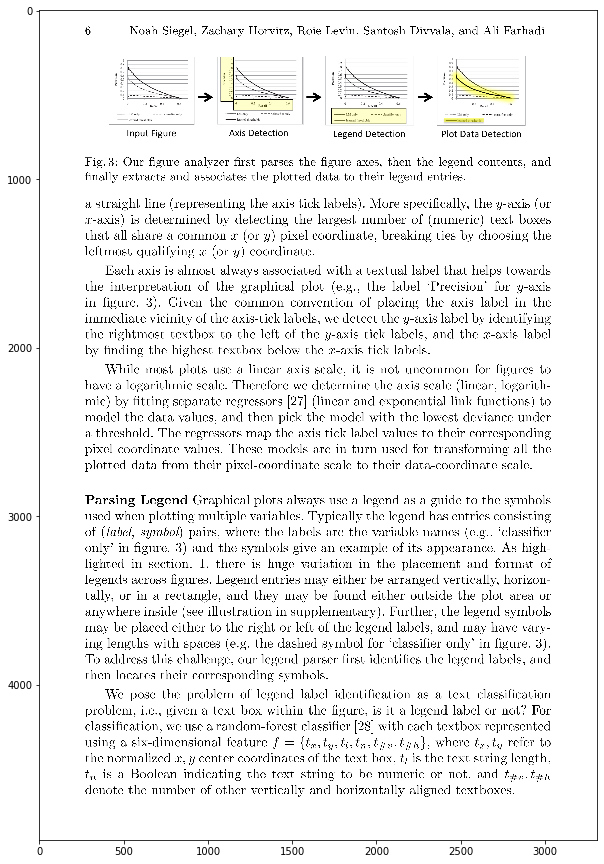

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,20))
plt.imshow(img);

### Extract Text & Images

Use one of the following strings for opt to obtain different formats [2]:

    “text”: (default) plain text with line breaks. No formatting, no text position details, no images.
    “blocks”: generate a list of text blocks (= paragraphs).
    “words”: generate a list of words (strings not containing spaces).
    “html”: creates a full visual version of the page including any images. This can be displayed with your internet browser.
    “dict” / “json”: same information level as HTML, but provided as a Python dictionary or resp. JSON string. See TextPage.extractDICT() resp. TextPage.extractJSON() for details of its structure.
    “rawdict”: a super-set of TextPage.extractDICT(). It additionally provides character detail information like XML. See TextPage.extractRAWDICT() for details of its structure.
    “xhtml”: text information level as the TEXT version but includes images. Can also be displayed by internet browsers.
    “xml”: contains no images, but full position and font information down to each single text character. Use an XML module to interpret.

To get an idea about the output of these alternatives, see [Appendix 2: Details on Text Extraction](https://pymupdf.readthedocs.io/en/latest/app2/#appendix2).

In [17]:
text_options = {
    'text', 'blocks', 'words', 'html', 
    'dict', 'json', 'rawDict', 'xhtml', 'xml'}

opt = 'text'

text = page.getText(opt)

text

'6\nNoah Siegel, Zachary Horvitz, Roie Levin, Santosh Divvala, and Ali Farhadi\nFig. 3: Our ﬁgure analyzer ﬁrst parses the ﬁgure axes, then the legend contents, and\nﬁnally extracts and associates the plotted data to their legend entries.\na straight line (representing the axis tick labels). More speciﬁcally, the y-axis (or\nx-axis) is determined by detecting the largest number of (numeric) text boxes\nthat all share a common x (or y) pixel coordinate, breaking ties by choosing the\nleftmost qualifying x (or y) coordinate.\nEach axis is almost always associated with a textual label that helps towards\nthe interpretation of the graphical plot (e.g., the label ‘Precision’ for y-axis\nin ﬁgure. 3). Given the common convention of placing the axis label in the\nimmediate vicinity of the axis-tick labels, we detect the y-axis label by identifying\nthe rightmost textbox to the left of the y-axis tick labels, and the x-axis label\nby ﬁnding the highest textbox below the x-axis tick labels.\nWh

### Search for Text

In [18]:
rectangles = page.searchFor('We', hit_max = 16)

rectangles

[Rect(211.26063537597656, 224.10699462890625, 222.6080322265625, 234.06959533691406),
 Rect(187.97801208496094, 273.7499694824219, 199.31546020507812, 283.71258544921875),
 Rect(291.99755859375, 297.3489685058594, 303.3349914550781, 307.31158447265625),
 Rect(48.959983825683594, 502.8319396972656, 62.79803466796875, 512.7945556640625),
 Rect(94.06057739257812, 526.4309692382812, 105.39801788330078, 536.3935546875)]

## More Features...

- PDF Maintenance: can only modify in PDF format, first convert to PDF using `doc.convertToPDF()`, after modifying, save to disk with `doc.save()`.
- Join & Split PDF documents
- Modify, Create, Re-arrange & Delete PDF pages
- Embed arbitrary data (similar to ZIP files)